In [5]:
import os
import sys
import random
import io
import requests
import pandas as pd
import numpy as np
import dicom
import matplotlib.pyplot as plt
sys.path.append('/home/mingot/lung_cancer_ds_bowl/src')
from utils import plotting, reading, preprocessing
from dl_model_patches import common

INPUT_FOLDER = '/home/shared/data/stage1'
NEW_SPACING = np.array([2, 0.7, 0.7])


# Get nodules df from annotation tool
url = "http://34.198.153.25:8009/patients/dsb_annotations.csv"
s = requests.get(url).content
annotations_df = pd.read_csv(io.StringIO(s.decode('utf-8')))
print 'Pacientes anotados con herramienta:', len(set(annotations_df['patientid']))

# Get patches
SCORE_TH = 0.4
#preds_df = pd.read_csv('/home/shared/output/resnet/nodules_patches_dl1_v11.csv')
preds_df = pd.read_csv('/home/shared/output/resnet/nodules_patches_dl1_v18.csv')
preds_df = preds_df[preds_df["score"] > SCORE_TH]
print 'patches df shape', preds_df.shape

# Get suggested annotations

# be: '33dd6666d9f0338929ecce58bb7c4cc3'
# reverse: '348a53f500ada390ddd00cc47d310b2c'
# reverse:

Pacientes anotados con herramienta: 270
patches df shape (76390, 7)


Patient ID: a13d6c5f8f86d74e16c10cf9294bca31
ORIENTATION: 38.9
Patient original shape: (141, 512, 512)
Patient new shape: [ 141.  491.  491.]
Cropping adjustment: -11


                            patientid  has_cancer  nslice    x    y  height  \
105  a13d6c5f8f86d74e16c10cf9294bca31           1      42  151  348      37   

     width  
105     39  
                                        patientid  nslice    x    y  diameter  \
2637051  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      17  310  318     4.787   
2637064  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      18  308  318     3.385   
2637174  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      27  259  287     5.046   
2637244  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      30  260  139     5.754   
2637278  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      31  259  140     4.514   
2637352  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      34  269  295     7.736   
2637381  dsb_a13d6c5f8f86d74e16c10cf9294bca31.npz      35  276  293    15.054  

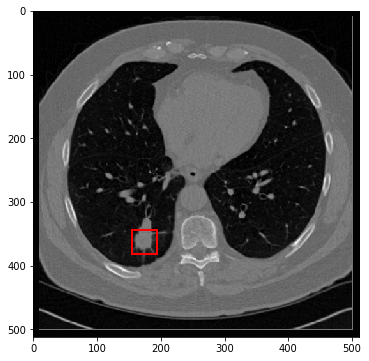

Predictions
Empty DataFrame
Columns: [patientid, nslice, x, y, diameter, score, label]
Index: []


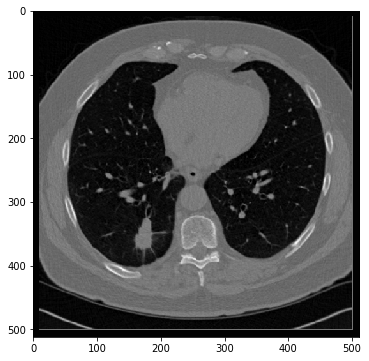

Rois


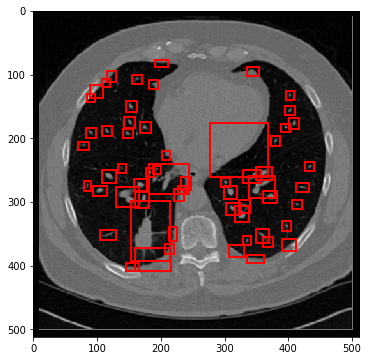

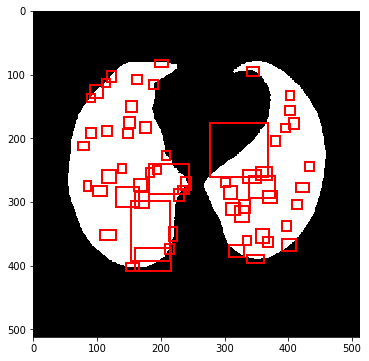

In [8]:
## Visualize FN

patid = 'a13d6c5f8f86d74e16c10cf9294bca31'
#patid = random.choice(list(set(annotations_df['patientid'])))
print 'Patient ID:', patid

# Get patient data
patidf = "/mnt/hd2/preprocessed5/dsb_%s.npz" % patid
pdata = np.load(patidf)['arr_0']
# plt.imshow(pdata[0,80])
# plt.show()

# plotting.multiplot(pdata[1])
# plt.bar(range(pdata.shape[1]), [np.sum(pdata[1,i]) for i in range(pdata.shape[1])])
# plt.show()


# Filter annotations and patches
preds_df_sel = preds_df[preds_df['patientid']=="dsb_%s.npz" % patid]
df = annotations_df[annotations_df['patientid']==patid]

# Get spacing factor
patient = reading.load_scan(os.path.join(INPUT_FOLDER, patid))
print 'ORIENTATION:', patient[0].SliceLocation
patient_pixels = preprocessing.get_pixels_hu(patient)
original_spacing = reading.dicom_get_spacing(patient)
sf = original_spacing/NEW_SPACING #scale_factor
print "Patient original shape:", patient_pixels.shape
new_shape = np.round(patient_pixels.shape*sf)
print "Patient new shape:", new_shape
crop_adj = int(new_shape[1] - 512)/2
print "Cropping adjustment:", crop_adj
print "\n"

print df
print preds_df_sel

for idx, row in df.iterrows():
    nslice,x,y,w,h = row['nslice'],row['x'],row['y'],row['height'],row['width']
    nslice = patient_pixels.shape[0] - nslice  # OJO: sometimes the z is inverted
    x -= crop_adj
    y -= crop_adj
    nslice,x,y,width,height = int(nslice*sf[0]),int(x*sf[1]),int(y*sf[1]),int(h*sf[1]),int(w*sf[1])

    a = common.AuxRegion(bbox=[y,x,y+w,x+h])
    print "Real nodules (slice: %d)" % nslice
    plotting.plot_bb(pdata[0,nslice], [a])

    print "Predictions"
    print preds_df_sel[preds_df_sel['nslice']==nslice]
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)
    
#     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==91]) 
#     plotting.plot_bb(pdata[0,nslice], pred_regions)
#     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==62]) 
#     plotting.plot_bb(pdata[0,nslice], pred_regions)
#     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==63]) 
#     plotting.plot_bb(pdata[0,nslice], pred_regions)
    
    print "Rois"
    rois = common.extract_rois_from_lung_mask(pdata[0,nslice], pdata[1,nslice])
    plotting.plot_bb(pdata[0,nslice], rois)
    plotting.plot_bb(pdata[1,nslice], rois)

    
# #     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice+1]) 
# #     plotting.plot_bb(pdata[0,nslice+1], pred_regions)
# #     pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice-1]) 
# #     plotting.plot_bb(pdata[0,nslice-1], pred_regions)
    


Patient ID: e163325ccf00afde107c80dfce2bce80, has cancer:0
                                        patientid  nslice    x    y  diameter  \
9889683  dsb_e163325ccf00afde107c80dfce2bce80.npz      62  254  196    10.093   
9890103  dsb_e163325ccf00afde107c80dfce2bce80.npz      79  259  191    36.893   
9890328  dsb_e163325ccf00afde107c80dfce2bce80.npz      88  220  199    11.056   
9890732  dsb_e163325ccf00afde107c80dfce2bce80.npz      98  275  226    10.218   

           score  label  
9889683  0.95719      0  
9890103  0.96891      0  
9890328  0.99186      0  
9890732  0.99609      0  
Slice: 62


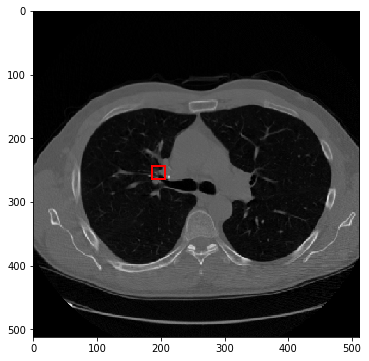

Slice: 79


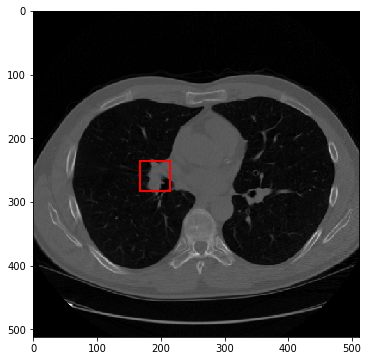

Slice: 88


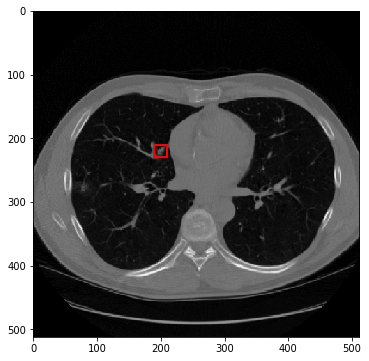

Slice: 98


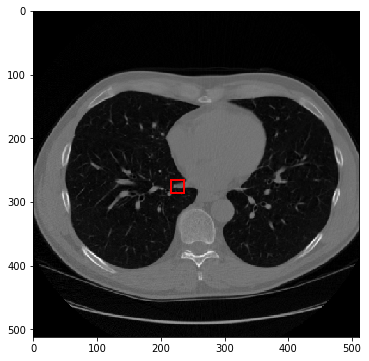

In [37]:
## Visualize FP

cancer_df = pd.read_csv('/home/mingot/lung_cancer_ds_bowl/data/stage1_labels.csv')

# patid = '5968ac45330d7f24b041a73925818269'
sels = list(set(preds_df[preds_df['patientid'].str.startswith('dsb')]['patientid']))
patid = random.choice([p.split('.')[-2].split('_')[-1] for p in sels])
print 'Patient ID: %s, has cancer:%d' % (patid, int(cancer_df[cancer_df['id']==patid]['cancer']))

# Get patient data
patidf = "/mnt/hd2/preprocessed5/dsb_%s.npz" % patid
pdata = np.load(patidf)['arr_0']

preds_df_sel = preds_df[preds_df['patientid']=="dsb_%s.npz" % patid]
preds_df_sel = preds_df_sel[(preds_df_sel['diameter']>10) & (preds_df_sel['score']>0.9)]
#df = annotations_df[annotations_df['patientid']==patid]

print preds_df_sel

for idx, row in preds_df_sel.iterrows():
    nslice,x,y,diameter = row['nslice'],row['x'],row['y'],row['diameter']
    print "Slice:", nslice
    pred_regions = common.extract_rois_from_df(preds_df_sel[preds_df_sel['nslice']==nslice]) 
    plotting.plot_bb(pdata[0,nslice], pred_regions)

In [6]:
## Evaluate nodules

tp = 0
total = annotations_df.shape[0]
for idx, row in annotations_df.iterrows():
    patid,nslice,x,y,w,h = row['patientid'],row['nslice'],row['x'],row['y'],row['height'],row['width']
    
    patient = reading.load_scan(os.path.join(INPUT_FOLDER, patid))
    patient_pixels = preprocessing.get_pixels_hu(patient)
    original_spacing = reading.dicom_get_spacing(patient)
    sf = original_spacing/NEW_SPACING #scale_factor
    new_shape = np.round(patient_pixels.shape*sf)
    crop_adj = int(new_shape[1] - 512)/2

    
    nslice = patient_pixels.shape[0] - nslice  # OJO: sometimes the z is inverted
    x -= crop_adj
    y -= crop_adj
    nslice,x,y,width,height = int(nslice*sf[0]),int(x*sf[1]),int(y*sf[1]),int(h*sf[1]),int(w*sf[1])
    
    print "Patient %s, nslice %d (%d/%d)" % (patid, nslice, idx, total)
    
    region_real = common.AuxRegion(bbox=[y,x,y+w,x+h])
    
    preds_df_sel = preds_df[(preds_df['nslice']==nslice) & (preds_df['patientid']=="dsb_%s.npz" % patid)]
    pred_regions = common.extract_rois_from_df(preds_df_sel)
    
    for region_pred in pred_regions:
        print "++ region with intersection", common.intersection_regions(region_real, region_pred)
        if common.intersection_regions(region_real, region_pred)>0.1:
            print '++ TP found!'
            tp += 1
    
print "Total TPs %d/%d, with %d candidates" % (tp, total, preds_df.shape[0])
    

Patient 00edff4f51a893d80dae2d42a7f45ad1, nslice 48 (0/366)
Patient fc545aa2f58509dc6d81ef02130b6906, nslice 55 (1/366)
++ region with intersection 0.717131474104
++ TP found!
Patient 90409f7fcfec3581033559f8340e48a9, nslice 69 (2/366)
Patient 90409f7fcfec3581033559f8340e48a9, nslice 32 (3/366)
++ region with intersection 0.37037037037
++ TP found!
++ region with intersection 0.0
Patient 51bd5c556c77ecdaf489d8dd9f7a05f1, nslice 87 (4/366)
Patient a162d204827e4e89a2e5ba81cc53247a, nslice 45 (5/366)
Patient e00832e96709eb85f8e0e608ca02c2b5, nslice 30 (6/366)
++ region with intersection 0.844741235392
++ TP found!
Patient c8cfb917b0d619cb4e25f789db4641f8, nslice 18 (7/366)
Patient 823b5f08ce145f837066d2e19dab10c1, nslice 99 (8/366)
++ region with intersection 0.0
++ region with intersection 0.653261402648
++ TP found!
Patient 823b5f08ce145f837066d2e19dab10c1, nslice 94 (9/366)
++ region with intersection 0.0
++ region with intersection 0.0
Patient f42a0343e5b5154c6a184fc955d8f20f, nslice 

                                   patientid  nslice       x      y    score  \
16  dsb_e10c2b829c39d4a500c09caf04d461a1.npz    76.0  274.00  229.0  0.80247   
22  dsb_e10c2b829c39d4a500c09caf04d461a1.npz    83.0  184.00  399.0  0.97007   
24  dsb_89629540f3b3cbc2a18d9919facd34d0.npz    22.0  355.00  193.0  0.81762   
25  dsb_89629540f3b3cbc2a18d9919facd34d0.npz    24.0  359.00  190.0  0.87802   
50   luna_119304665257760307862874140576.npz    15.0  333.00  365.0  0.71509   
56   luna_119304665257760307862874140576.npz    25.5  265.75   62.5  0.99857   
59   luna_119304665257760307862874140576.npz    30.0  315.00  277.0  0.71339   
60   luna_119304665257760307862874140576.npz    31.0  198.00  391.0  0.72320   
72   luna_119304665257760307862874140576.npz    63.0  154.00  118.0  0.84900   
75   luna_119304665257760307862874140576.npz    66.0  164.00  105.0  0.85789   

       PC1_lbp  diameter  10_lungmask  
16  -33.758130     4.652       0.7808  
22   37.377507     7.399       0.5584  

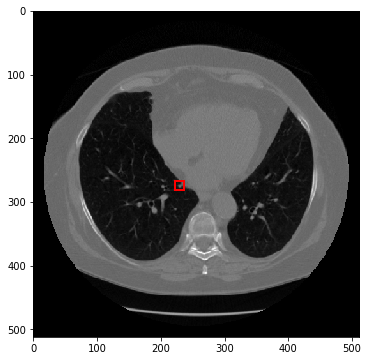

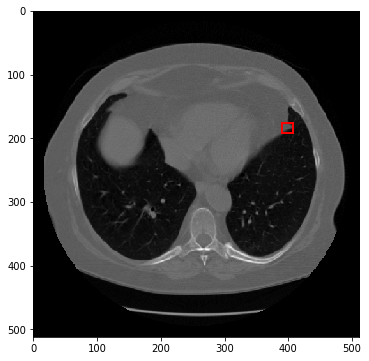

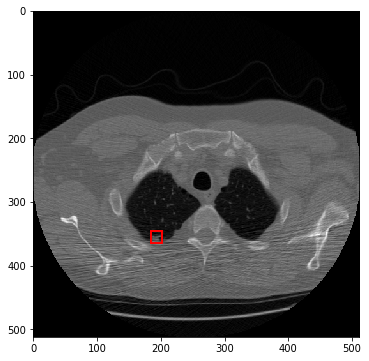

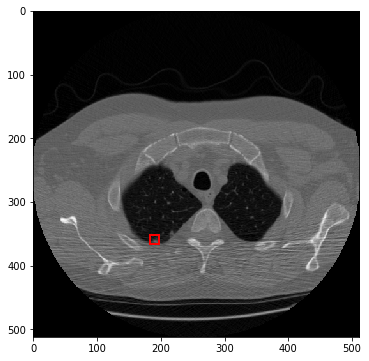

Patient luna_119304665257760307862874140576.npz not found
Patient luna_119304665257760307862874140576.npz not found
Patient luna_119304665257760307862874140576.npz not found
Patient luna_119304665257760307862874140576.npz not found
Patient luna_119304665257760307862874140576.npz not found
Patient luna_119304665257760307862874140576.npz not found


In [23]:
nod_df = pd.read_csv('/home/shared/output/resnet/nodules_patches_dl1_v11_score07_noduleaggr_augmented.csv')
nod_df
#xx_df = nod_df[nod_df['PC1_lbp']>112][['patientid','nslice','x','y','score','PC1_lbp','diameter']][0:20]
xx_df = nod_df[nod_df['10_lungmask']<0.8][['patientid','nslice','x','y','score','PC1_lbp','diameter','10_lungmask']][0:10]
print xx_df

for idx, row in xx_df.iterrows():
    patientid, nslice = row['patientid'], row['nslice']
    try:
        pdata = np.load('/mnt/hd2/preprocessed5/%s'%patientid)['arr_0']
    except:
        print "Patient %s not found" % patientid
        continue
    sel_df = xx_df[(xx_df['nslice']==nslice) & (xx_df['patientid']==patientid)]
    pred_regions = common.extract_rois_from_df(sel_df) 
    plotting.plot_bb(pdata[0,int(nslice)], pred_regions)

